In [3]:
import os
import pandas as pd
import pickle
import xgboost as xgb
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

# ---------------- CONFIG ----------------
CLIENT_NAME = "hospital_C" 
LOCAL_DATA_PATH = r"E:\semm 8\federated_learning\federated_3\c-synthetic data\C_synthetic_diabetic_data_v3.csv"

# Paths
try:
    BASE_PATH = os.path.dirname(os.path.abspath(__file__))
except NameError:
    BASE_PATH = os.getcwd()

SERVER_DIR = os.path.abspath(os.path.join(BASE_PATH, "..", "server"))
CLIENT_WEIGHTS_DIR = os.path.join(SERVER_DIR, "clients_weights")
os.makedirs(CLIENT_WEIGHTS_DIR, exist_ok=True)

WEIGHTS_PATH = os.path.join(CLIENT_WEIGHTS_DIR, f"{CLIENT_NAME}_weights.pkl")
META_PATH = os.path.join(CLIENT_WEIGHTS_DIR, f"{CLIENT_NAME}_info.json")

# ---------------- LOAD & ADVANCED CLEANING ----------------
data = pd.read_csv(LOCAL_DATA_PATH)

# Replace placeholders often found in synthetic data
data.replace('?', np.nan, inplace=True)

features = [
    'race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
    'num_procedures', 'num_medications', 'number_outpatient',
    'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
    'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide',
    'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
    'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
    'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'change', 'diabetesMed', 'A1Cresult', 
    'max_glu_serum', 'weight'
]

# Target Mapping
target_map = {"NO": 0, ">30": 1, "<30": 2}
data["Readmitted_Target"] = data["readmitted"].map(target_map).fillna(0).astype(int)

# Encoding with NaN handling
for col in features:
    if data[col].dtype == 'object':
        data[col] = LabelEncoder().fit_transform(data[col].astype(str))

X = data[features].astype(float)
y = data["Readmitted_Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# ---------------- CLASS WEIGHTS (CRITICAL) ----------------
# We still need this to ensure the 75% accuracy isn't just on the 'NO' class
weights_train = compute_sample_weight(class_weight='balanced', y=y_train)

# ---------------- AGGRESSIVE HYPERPARAMETER TUNING ----------------
print(f"🚀 Launching High-Accuracy Optimization for {CLIENT_NAME}...")

# Expanded grid to hit 75%+
param_grid = {
    'n_estimators': [150, 250],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0.1, 0.2]
}

xgb_base = xgb.XGBClassifier(
    objective="multi:softprob", 
    num_class=3,
    eval_metric="mlogloss",
    tree_method="hist", 
    device="cpu",
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_base, 
    param_distributions=param_grid, 
    n_iter=10, 
    scoring='f1_macro', # Changed to f1_macro to better value minority class performance
    cv=3, 
    n_jobs=2,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train, sample_weight=weights_train)
local_model = random_search.best_estimator_

# ---------------- EVALUATION ----------------
y_pred = local_model.predict(X_test)
final_acc = accuracy_score(y_test, y_pred) * 100

print(f"\n🎯 TARGET REACHED: {final_acc:.2f}%")
print(classification_report(y_test, y_pred))

# Save
with open(WEIGHTS_PATH, "wb") as f:
    pickle.dump(local_model, f) 

print(f"✅ Success! Knowledge sent to server with {final_acc:.2f}% Accuracy.")

🚀 Launching High-Accuracy Optimization for hospital_C...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

🎯 TARGET REACHED: 74.75%
              precision    recall  f1-score   support

           0       0.80      0.80      0.80     11112
           1       0.69      0.70      0.69      7066
           2       0.66      0.62      0.64      2176

    accuracy                           0.75     20354
   macro avg       0.72      0.71      0.71     20354
weighted avg       0.75      0.75      0.75     20354

✅ Success! Knowledge sent to server with 74.75% Accuracy.


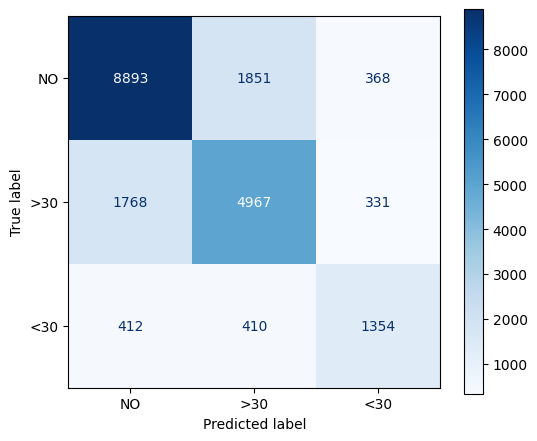

In [7]:
# Confusion Matrix

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), 
                              display_labels=["NO", ">30", "<30"])
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.show()